In [1]:
!pip install tslearn lightgbm matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 3.1 MB/s eta 0:00:00


In [2]:
import numpy as np
from sklearn.metrics import accuracy_score
import tensorflow as tf
import matplotlib.pyplot as plt

from tslearn.preprocessing import TimeSeriesScalerMinMax
from tslearn.shapelets import LearningShapelets, grabocka_params_to_shapelet_size_dict
from tslearn.utils import ts_size
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import tslearn
from tslearn.shapelets import LearningShapelets
from tslearn.shapelets import ShapeletModel, grabocka_params_to_shapelet_size_dict
from tslearn.utils import to_time_series_dataset
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical
import lightgbm as lgb
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
import random
import datetime


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
path = '/content/drive/MyDrive/real data v1/'
activity=['clap','wave','circle','push']
position = ['i','ii','iii','iv','v','vi','vii','viii','ix']

dfs=[]
labels =[]
count = 0
window_size = 200
mn = 2000
mx = 0
for i in activity:
    plotted = False;
    for j in position:
        for k in range(1,11):
            s=f"{path}{i}_parsed_data/{i}/{i}_{j}{k}.csv"
            df = pd.read_csv(s)

            dfs.append(df)
            labels.append(i)
            count = count+ df.shape[0]//window_size
            if(df.shape[0]%window_size >0):
              count = count+1

            mx = max(mx, df.shape[0])
            mn = min(mn, df.shape[0])

print(f"mn = {mn}, mx = {mx}, count of sequences = {count}")

mn = 234, mx = 1074, count of sequences = 1233


In [ ]:
len(dfs), len(labels)

(360, 360)

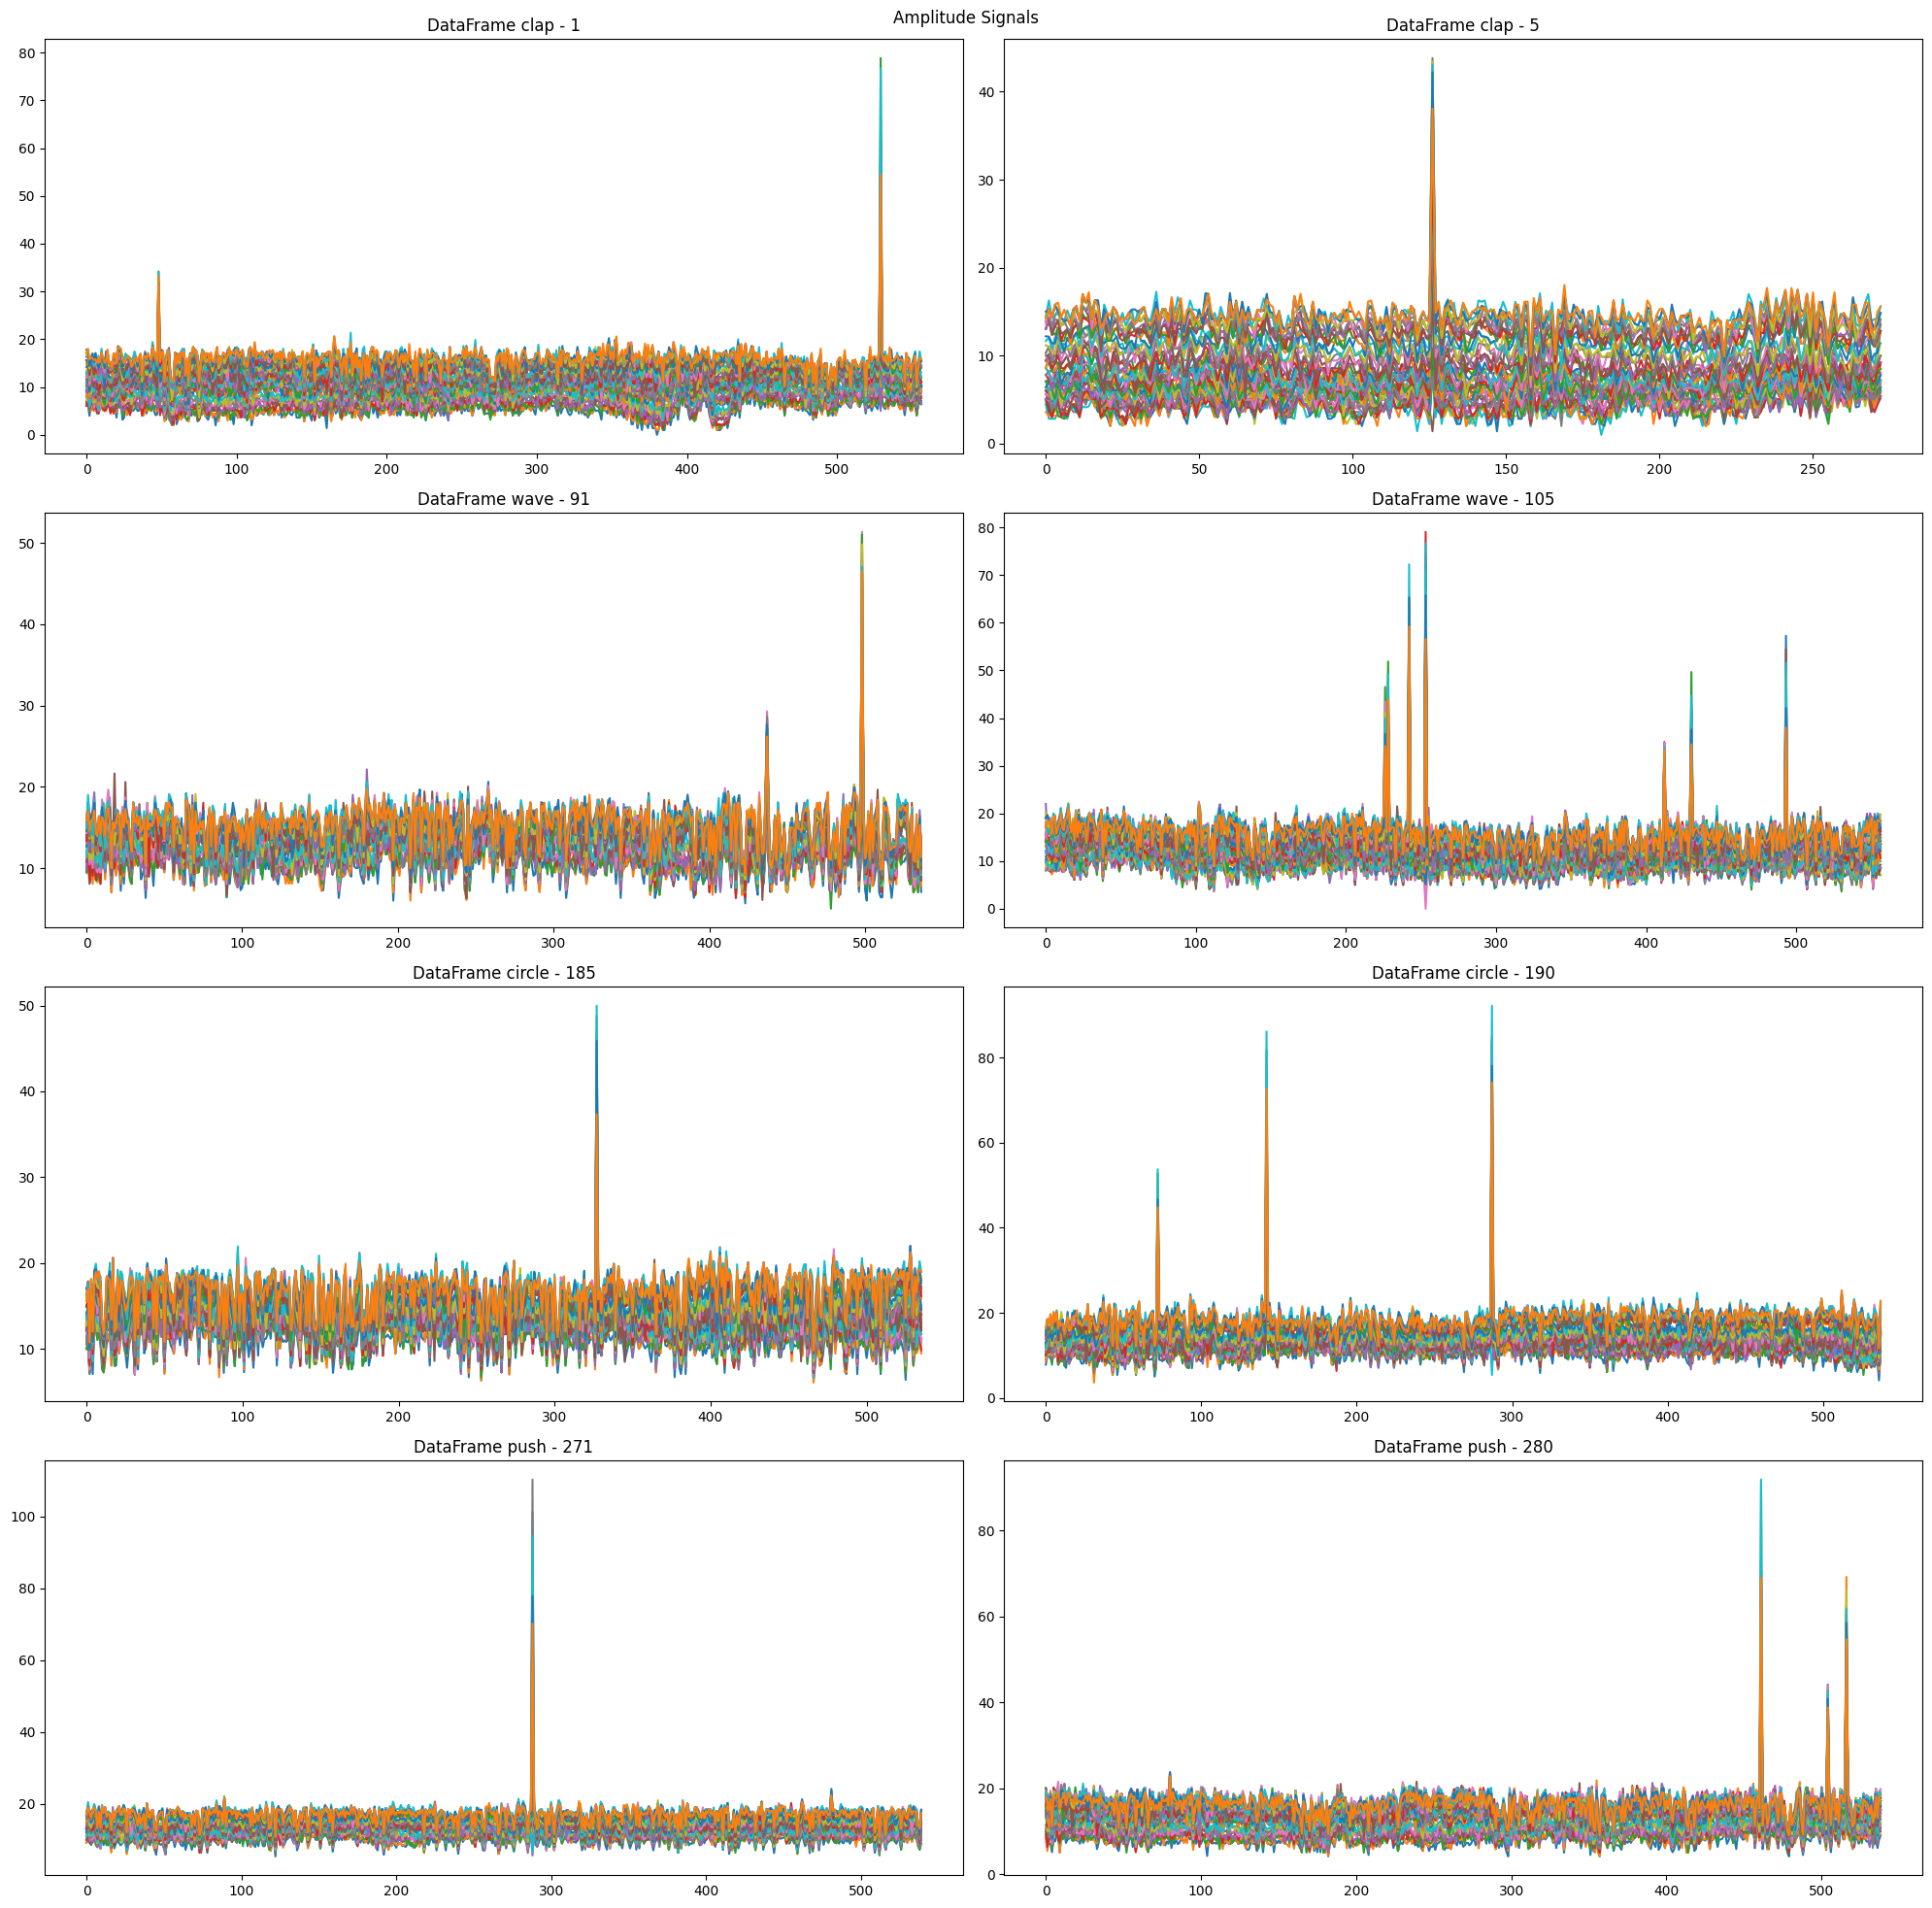

In [ ]:
fig = plt.figure(figsize=(20, 20))
fig.suptitle("Amplitude Signals")

n = len(dfs)

j=[1,5,91,105,185,190,271, 280]
for i in range(8):
    label = labels[j[i]]
    df = dfs[j[i]]
    x = df.iloc[:, 1:53].values
    plot = plt.subplot2grid((4,2), (count // 2, count % 2))
    plot.plot(x)
    plot.set_title(f"DataFrame {label} - {j[i]}")  # Adding label to title for clarity

plt.tight_layout()
plt.show()


In [5]:
def Labeling(label):
  if label=="clap":
    return  0
  elif label=="circle":
    return 1
  elif label=="push":
    return 2
  else:
    return 3

X = np.empty((count, window_size, 52))
y = np.empty(count)
k=0

for i in range(len(dfs)):
  label = labels[i]
  df = dfs[i]
  df = df.drop(df.columns[53:105], axis=1)
  df = df.drop(df.columns[0], axis=1)

  num_of_windows = df.shape[0]//window_size

  for j in range(num_of_windows):
    start = j*window_size
    end = start+window_size
    if(end<=df.shape[0]):
      X[k] = df[start:end]
      y[k] = Labeling(label)
      k=k+1
    else:
      break

  if (df.shape[0]%window_size)>0:
    X[k] = df[-window_size:]
    y[k] = Labeling(label)
    k=k+1

In [6]:
X.shape, y.shape, np.unique(y)

((1233, 200, 52), (1233,), array([0., 1., 2., 3.]))

In [7]:
X = TimeSeriesScalerMinMax().fit_transform(X)
X.shape

(1233, 200, 52)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((986, 200, 52), (986,), (247, 200, 52), (247,))

In [10]:
# Get statistics of the dataset
n_ts, ts_sz = X_train.shape[:2]
n_classes = len(set(y_train))

# Set the number of shapelets per size as done in the original paper
shapelet_sizes = grabocka_params_to_shapelet_size_dict(n_ts=n_ts,
                                                       ts_sz=ts_sz,
                                                       n_classes=n_classes,
                                                       l=0.1,
                                                       r=1)
print(shapelet_sizes)

{20: 5}


In [ ]:
import inspect
inspect.getsource(grabocka_params_to_shapelet_size_dict)

'def grabocka_params_to_shapelet_size_dict(n_ts, ts_sz, n_classes, l, r):\n    """Compute number and length of shapelets.\n\n     This function uses the heuristic from [1]_.\n\n    Parameters\n    ----------\n    n_ts: int\n        Number of time series in the dataset\n    ts_sz: int\n        Length of time series in the dataset\n    n_classes: int\n        Number of classes in the dataset\n    l: float\n        Fraction of the length of time series to be used for base shapelet\n        length\n    r: int\n        Number of different shapelet lengths to use\n\n    Returns\n    -------\n    dict\n        Dictionary giving, for each shapelet length, the number of such\n        shapelets to be generated\n\n    Examples\n    --------\n    >>> d = grabocka_params_to_shapelet_size_dict(\n    ...         n_ts=100, ts_sz=100, n_classes=3, l=0.1, r=2)\n    >>> keys = sorted(d.keys())\n    >>> print(keys)\n    [10, 20]\n    >>> print([d[k] for k in keys])\n    [4, 4]\n\n\n    References\n    ---

In [ ]:
def grabocka_params_to_shapelet_size_dict(n_ts, ts_sz, n_classes, l, r):

    base_size = int(l * ts_sz)
    base_size = max(base_size, 1)
    r = min(r, ts_sz)
    d = {}
    for sz_idx in range(r):
        shp_sz = base_size * (sz_idx + 1)
        n_shapelets = int(np.log10(n_ts *
                                      (ts_sz - shp_sz + 1) *
                                      (n_classes - 1)))
        n_shapelets = max(1, n_shapelets)
        d[shp_sz] = n_shapelets
    return d


In [11]:
# Define the model using parameters provided by the authors
shp_clf = LearningShapelets(n_shapelets_per_size=shapelet_sizes,
                            optimizer=tf.optimizers.Adam(0.001),
                            batch_size=16,
                            weight_regularizer=0.01,
                            max_iter=1000,
                            random_state=42,
                            verbose=1,
                            scale=True)

In [12]:
shp_clf.fit(X_train, y_train)

Epoch 1/1000
62/62 [==============================] - 27s 93ms/step - loss: 2.2223 - categorical_accuracy: 0.2424 - categorical_crossentropy: 2.1783
Epoch 2/1000
62/62 [==============================] - 6s 90ms/step - loss: 1.5580 - categorical_accuracy: 0.2424 - categorical_crossentropy: 1.5153
Epoch 3/1000
62/62 [==============================] - 3s 49ms/step - loss: 1.4475 - categorical_accuracy: 0.2373 - categorical_crossentropy: 1.4052
Epoch 4/1000
62/62 [==============================] - 3s 49ms/step - loss: 1.4398 - categorical_accuracy: 0.2566 - categorical_crossentropy: 1.3979
Epoch 5/1000
62/62 [==============================] - 3s 48ms/step - loss: 1.4320 - categorical_accuracy: 0.2525 - categorical_crossentropy: 1.3903
Epoch 6/1000
62/62 [==============================] - 5s 78ms/step - loss: 1.4213 - categorical_accuracy: 0.2708 - categorical_crossentropy: 1.3799
Epoch 7/1000
62/62 [==============================] - 4s 62ms/step - loss: 1.4164 - categorical_accuracy: 0.275

LearningShapelets(batch_size=16, max_iter=1000, n_shapelets_per_size={20: 5},
                  optimizer=<keras.src.optimizers.adam.Adam object at 0x7c78940ffcd0>,
                  random_state=42, scale=True, verbose=1,
                  weight_regularizer=0.01)

In [13]:
# Make predictions and calculate accuracy score
pred_labels = shp_clf.predict(X_test)
print("Correct classification rate:", accuracy_score(y_test, pred_labels))

16/16 [==============================] - 4s 49ms/step
Correct classification rate: 0.7449392712550608


In [14]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calculate accuracy for ensemble model
shapelet_accuracy = accuracy_score(y_test, pred_labels)

# Calculate precision for ensemble model
shapelet_precision = precision_score(y_test, pred_labels, average='weighted')

# Calculate recall for ensemble model
shapelet_recall = recall_score(y_test, pred_labels, average='weighted')

# Calculate F1 score for ensemble model
shapelet_f1 = f1_score(y_test, pred_labels, average='weighted')

# Check scores
print('Model scores with Shapelet Learning:')
print(f'Test accuracy: {shapelet_accuracy:.3f}')
print(f'Test precision: {shapelet_precision:.3f}')
print(f'Test recall: {shapelet_recall:.3f}')
print(f'Test F1 score: {shapelet_f1:.3f}')

Model scores with Shapelet Learning:
Test accuracy: 0.745
Test precision: 0.777
Test recall: 0.745
Test F1 score: 0.740


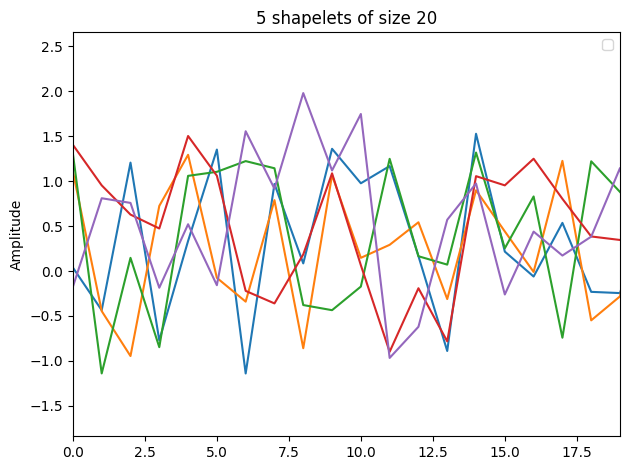

In [17]:
# Plot the different discovered shapelets
plt.figure()
for i, sz in enumerate(shapelet_sizes.keys()):
    plt.subplot(len(shapelet_sizes), 1, i + 1)
    plt.title("%d shapelets of size %d" % (shapelet_sizes[sz], sz))
    for shp in shp_clf.shapelets_:
        if ts_size(shp) == sz:
            plt.plot(shp.ravel())
    plt.xlim([0, max(shapelet_sizes.keys()) - 1])
    # plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.legend()

plt.tight_layout()
plt.show()

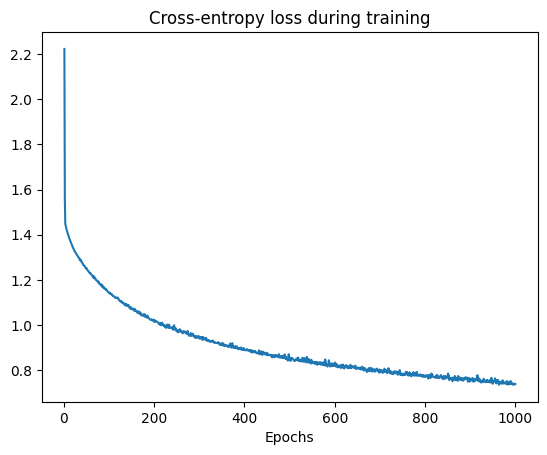

In [15]:
# The loss history is accessible via the `model_` that is a keras model
plt.figure()
plt.plot(np.arange(1, shp_clf.n_iter_ + 1), shp_clf.history_["loss"])
plt.title("Cross-entropy loss during training")
plt.xlabel("Epochs")
plt.show()

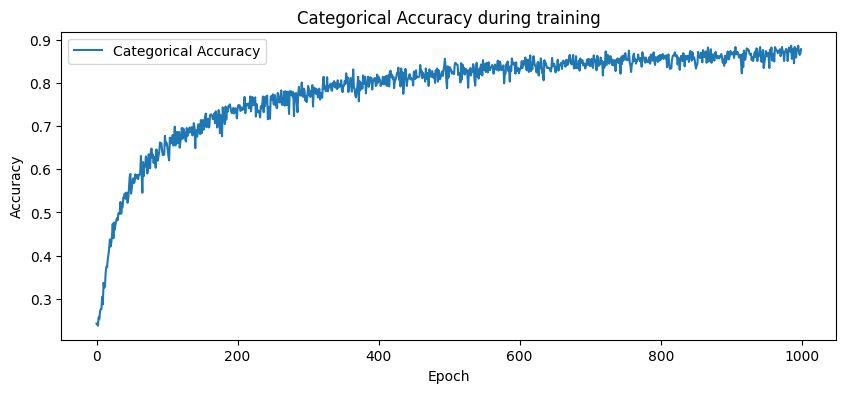

In [16]:
plt.figure(figsize=(10, 4))
plt.plot(shp_clf.history_['categorical_accuracy'], label='Categorical Accuracy')
plt.title('Categorical Accuracy during training')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

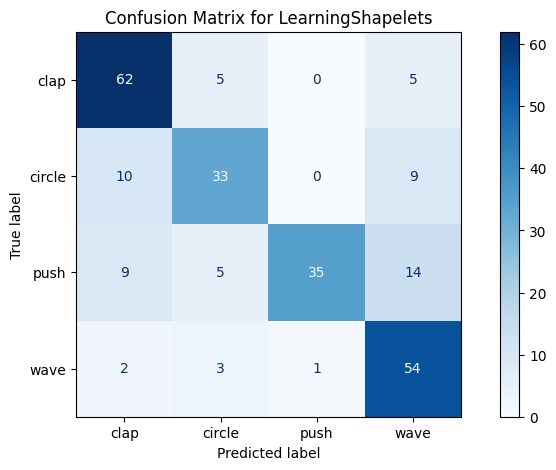

In [30]:
import matplotlib.pyplot as plt

from sklearn.metrics import ConfusionMatrixDisplay

target_names=['clap','circle','push','wave']
fig, ax = plt.subplots(figsize=(10, 5))
ConfusionMatrixDisplay.from_predictions(y_test, pred_labels, ax=ax, cmap='Blues')
ax.xaxis.set_ticklabels(target_names)
ax.yaxis.set_ticklabels(target_names)
_ = ax.set_title(
    f"Confusion Matrix for {shp_clf.__class__.__name__}"
)